## ARIMA
Vamos começar fazendo os imports e carregando o dataset.

In [14]:
import pandas as pd
import numpy as np
%matplotlib inline

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima # for determining ARIMA orders

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('Data/TradeInventories.csv',index_col='Date',parse_dates=True)
df.index.freq='MS'

In [15]:
df.head()

,Inventories
Date,
1997-01-01,1301161
1997-02-01,1307080
1997-03-01,1303978
1997-04-01,1319740
1997-05-01,1327294


Vamos dividir a série em treino e teste.

In [16]:
train = df[:int(0.9*(len(df)))]
test = df[int(0.9*(len(df))):]

In [17]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 237 entries, 1997-01-01 to 2016-09-01
Freq: MS
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Inventories  237 non-null    int64
dtypes: int64(1)
memory usage: 3.7 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 27 entries, 2016-10-01 to 2018-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Inventories  27 non-null     int64
dtypes: int64(1)
memory usage: 432.0 bytes


In [18]:
len(test)

27

E agora vamos plotar nossa série.

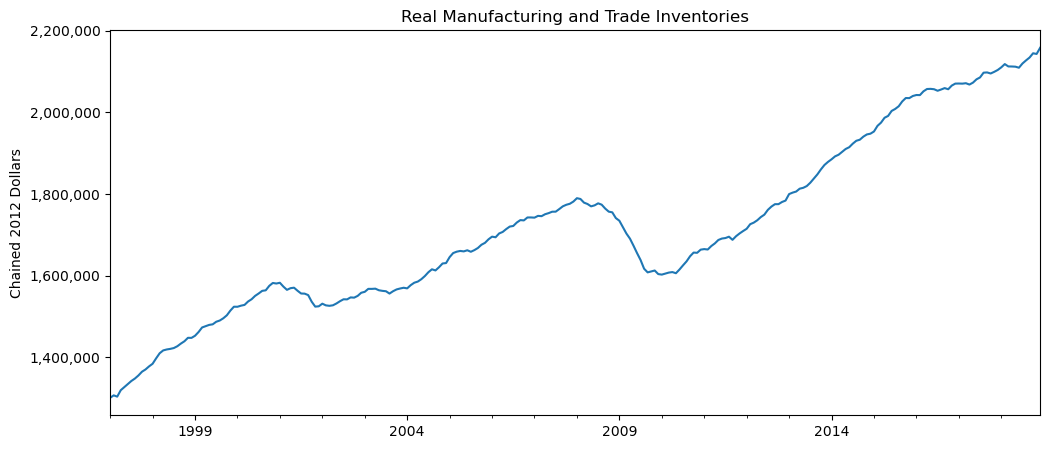

In [19]:
# HERE'S A TRICK TO ADD COMMAS TO Y-AXIS TICK VALUES
import matplotlib.ticker as ticker
formatter = ticker.StrMethodFormatter('{x:,.0f}')

title = 'Real Manufacturing and Trade Inventories'
ylabel='Chained 2012 Dollars'
xlabel='' # we don't really need a label here

ax = df['Inventories'].plot(figsize=(12,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

### Decomposição ETS (opcional)
Fazer a decomposição ETS pode nos ajudar a compreender melhor as características da nossa série temporal.

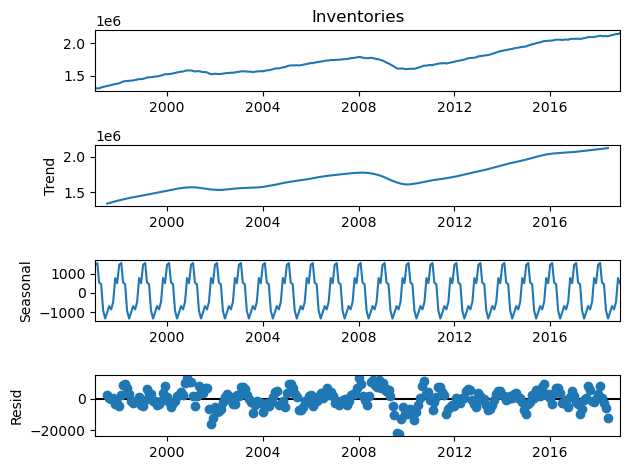

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df['Inventories'], model='additive')  # model='add' also works
result.plot();

Observamos que o componente sazonal não contribui significativamente para o comportamento da série.


### Usando auto_arima
Vamos usar a função *auto_arima* a fim de determinar as ordens de p, d e q.

In [21]:
auto_arima(train, seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  237
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2401.473
Date:                Tue, 04 Jun 2024   AIC                           4806.946
Time:                        18:34:57   BIC                           4813.873
Sample:                    01-01-1997   HQIC                          4809.738
                         - 09-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3212.7839    520.562      6.172      0.000    2192.502    4233.066
sigma2      4.037e+07   3.28e+06     12.290      0.000    3.39e+07    4.68e+07
===================================================================================
Ljung-Box (L1) (Q):                  86.83   Jarque-Bera (JB):               100.37
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.76   Skew:                            -1.22
Prob(H) (two-sided):                  0.21   Kurtosis:                         5.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Vamos agora fazer o teste Aumentado de Dickey-Fuller.

In [22]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Param: série temporal e um título opcional, retorna um relatório ADF

    """
    print(f'Teste Dickey-Fuller Aumentado: {title}')
    result = adfuller(series.dropna(),autolag='AIC') 
    
    labels = ['Estatística de teste ADF','p-value','# lags usados','# observações']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'Valor crítico ({key})']=val
        
    print(out.to_string())          # .to_string() remove a linha "dtype: float64"
    
    if result[1] <= 0.05:
        print("Evidência forte contra a hipótese nula.")
        print("Rejeitar a hipótese nula.")
        print("Dados não tem raiz unitária. Série estacionária.")
    else:
        print("Evidência fraca contra a hipótese nula.")
        print("Falha em rejeitar a hipótese nula.")
        print("Dados tem uma raiz unitária. Série não estacionária.")

In [23]:
adf_test(df['Inventories'],'Real Manufacturing and Trade Inventories')

Teste Dickey-Fuller Aumentado: Real Manufacturing and Trade Inventories
Estatística de teste ADF     -0.087684
p-value                       0.950652
# lags usados                 5.000000
# observações               258.000000
Valor crítico (1%)           -3.455953
Valor crítico (5%)           -2.872809
Valor crítico (10%)          -2.572775
Evidência fraca contra a hipótese nula.
Falha em rejeitar a hipótese nula.
Dados tem uma raiz unitária. Série não estacionária.


Temos, portanto, que fazer a primeira diferenciação e realizar o teste novamente.

In [24]:
from statsmodels.tsa.statespace.tools import diff
df['d1'] = diff(df['Inventories'],k_diff=1)

adf_test(df['d1'],'Real Manufacturing and Trade Inventories')

Teste Dickey-Fuller Aumentado: Real Manufacturing and Trade Inventories
Estatística de teste ADF     -3.412249
p-value                       0.010548
# lags usados                 4.000000
# observações               258.000000
Valor crítico (1%)           -3.455953
Valor crítico (5%)           -2.872809
Valor crítico (10%)          -2.572775
Evidência forte contra a hipótese nula.
Rejeitar a hipótese nula.
Dados não tem raiz unitária. Série estacionária.


Com uma diferenciação temos p < 0,05 -- portanto, a ordem de p = 1.

Vamos agora criar nosso modelo e realizar previsões.

In [25]:
arima_model = auto_arima(train, 
                        start_p=0,d = 1,start_q=0,
                        test="adf", supress_warnings = True,
                        trace=True)
 
#Summary of the model
arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4806.946, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4867.200, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4809.481, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4858.681, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4844.013, Time=0.16 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.484 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  237
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2401.473
Date:                Tue, 04 Jun 2024   AIC                           4806.946
Time:                        18:34:58   BIC                           4813.873
Sample:                    01-01-1997   HQIC                          4809.738
                         - 09-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3212.7839    520.562      6.172      0.000    2192.502    4233.066
sigma2      4.037e+07   3.28e+06     12.290      0.000    3.39e+07    4.68e+07
===================================================================================
Ljung-Box (L1) (Q):                  86.83   Jarque-Bera (JB):               100.37
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.76   Skew:                            -1.22
Prob(H) (two-sided):                  0.21   Kurtosis:                         5.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
test['Predicted'] = arima_model.predict(n_periods = len(test))
test.head()

,Inventories,Predicted
Date,,
2016-10-01,2056580,2.062591e+06
2016-11-01,2065534,2.065804e+06
2016-12-01,2070388,2.069016e+06
2017-01-01,2070587,2.072229e+06
2017-02-01,2070299,2.075442e+06


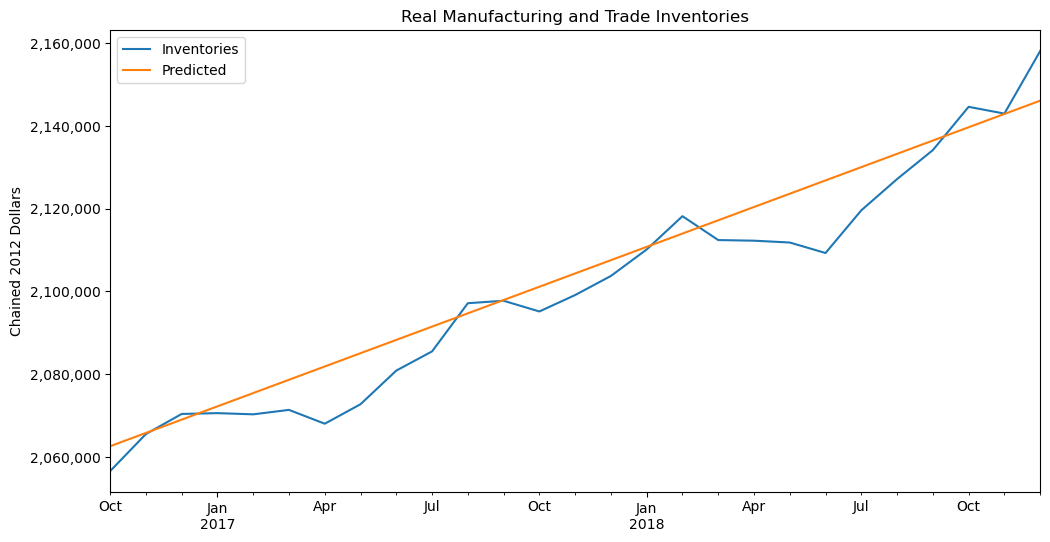

In [27]:
# Plot predictions against known values
title = 'Real Manufacturing and Trade Inventories'
ylabel='Chained 2012 Dollars'
xlabel='' # we don't really need a label here

ax = test['Inventories'].plot(legend=True,figsize=(12,6),title=title)
test['Predicted'].plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

Retreinando o modelo com todos os dados para realizar previsão.

In [33]:
arima_model = auto_arima(df['Inventories'], 
                        start_p=0,d = 1,start_q=0,
                        test="adf", supress_warnings = True,
                        trace=True)


fcast = arima_model.predict(n_periods = 12)
fcast

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5348.037, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5399.843, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5350.241, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5409.217, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5378.835, Time=0.16 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.451 seconds


2019-01-01    2.161373e+06
2019-02-01    2.164632e+06
2019-03-01    2.167890e+06
2019-04-01    2.171149e+06
2019-05-01    2.174407e+06
2019-06-01    2.177665e+06
2019-07-01    2.180924e+06
2019-08-01    2.184182e+06
2019-09-01    2.187440e+06
2019-10-01    2.190699e+06
2019-11-01    2.193957e+06
2019-12-01    2.197216e+06
Freq: MS, dtype: float64

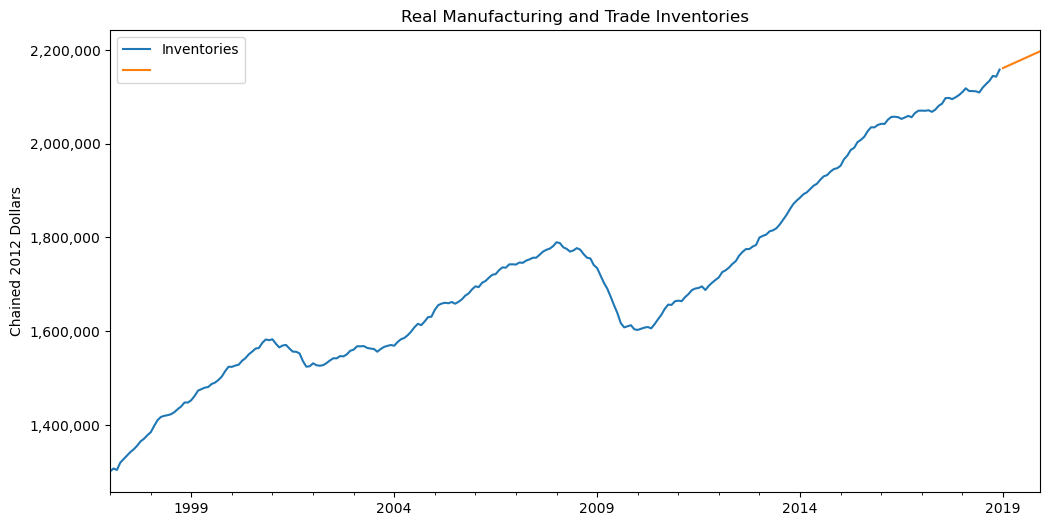

In [34]:
# Plot predictions against known values
title = 'Real Manufacturing and Trade Inventories'
ylabel='Chained 2012 Dollars'
xlabel='' # we don't really need a label here

ax = df['Inventories'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);